In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pandas_profiling
from pyod.models.knn import KNN

In [2]:
data_path = 'as_is.csv'
df = pd.read_csv(data_path)

In [3]:
profile = df.profile_report(title='EDA Profile')
profile.to_file(output_file="bgp_eda.html")

In [4]:
cols = list(df.columns)

df_normal = df.loc[df["Anomalous"] == -1]
df_anom   = df.loc[df["Anomalous"] ==  1]

df_train = df.sample(frac=0.8,random_state=1)
df_test = df.drop(df_train.index)

x_train = df_train[cols[0:37]]
y_train = df_train["Anomalous"]
y_train.loc[y_train == -1] = 0

x_test = df_test[cols[0:37]]
y_test = df_test["Anomalous"]
y_test.loc[y_test == -1] = 0



F:\Anaconda3\envs\bgp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)



# Baseline Models:
   The first set of models we will create are using the whole aggregated data set with minimal
   feature engineering. The models themselves will also have minimal tuning.
## KNN

In [5]:
#Compute contimination of anomamlies
n_norm = sum(df['Anomalous'] == -1)
n_anom = sum(df['Anomalous'] ==  1)
cont_factor = n_anom / (n_norm + n_anom)
print('Contamination Factor for whole data set: ',cont_factor * 100 , "%")

n_norm_train = sum(y_train == 0)
n_anom_train = sum(y_train ==  1)
cont_factor_train = n_anom_train / (n_norm_train + n_anom_train)
print('Contamination Factor for training set: ',cont_factor_train * 100 , "%")


Contamination Factor for whole data set:  16.513427702076992 %
Contamination Factor for training set:  16.544710405556245 %


In [6]:
clf_name = 'KNN'
clf = KNN(contamination=cont_factor_train)
clf.fit(x_train.to_numpy())

KNN(algorithm='auto', contamination=0.16544710405556246, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=1,
  n_neighbors=5, p=2, radius=1.0)

In [7]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [8]:
# get the prediction on the test data
y_test_pred = clf.predict(x_test.to_numpy())  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(x_test.to_numpy())  # outlier scores

In [9]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train.to_numpy(), y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test.to_numpy(), y_test_scores)


On Training Data:
KNN ROC:0.6373, precision @ rank n:0.2046

On Test Data:
KNN ROC:0.633, precision @ rank n:0.1937


## KNN with PCA

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_rescaled = scaler.fit_transform(x_train.to_numpy())
x_test_rescaled = scaler.fit_transform(x_test.to_numpy())


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(x_train_rescaled)
reduced = pca.transform(x_train_rescaled)
print(reduced.shape)

(24189, 12)


In [12]:
clf_2 = KNN(contamination=cont_factor_train)
clf_2.fit(reduced)

KNN(algorithm='auto', contamination=0.16544710405556246, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=1,
  n_neighbors=5, p=2, radius=1.0)

In [13]:
# get the prediction labels and outlier scores of the training data
y_train_pred_red = clf_2.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_red = clf_2.decision_scores_  # raw outlier scores

In [14]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train.to_numpy(), y_train_scores_red)


On Training Data:
KNN ROC:0.484, precision @ rank n:0.0947


## AutoEncoder

In [15]:
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
from keras.utils import plot_model

Using TensorFlow backend.


In [16]:
#Configuration
contamination = cont_factor_train
epochs = 30

In [17]:
clf_3 = AutoEncoder(epochs=epochs, contamination=contamination)
clf_3.fit(x_train.to_numpy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 37)                1406      
_________________________________________________________________
dropout_1 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 37)                1406      
_________________________________________________________________
dropout_2 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2432      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

AutoEncoder(batch_size=32, contamination=0.16544710405556246,
      dropout_rate=0.2, epochs=30, hidden_activation='relu',
      hidden_neurons=[64, 32, 32, 64], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000223A6C99AF8>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [18]:
y_train_pred = clf_3.labels_  
y_train_scores = clf_3.decision_scores_ 

In [21]:
print("\nOn Training Data:")
evaluate_print("Autoencoder", y_train.to_numpy(), y_train_scores)


On Training Data:
Autoencoder ROC:0.4193, precision @ rank n:0.1057


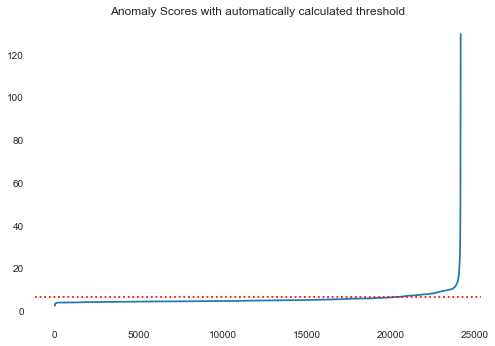

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.sort(y_train_scores));
plt.axhline(y=clf_3.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

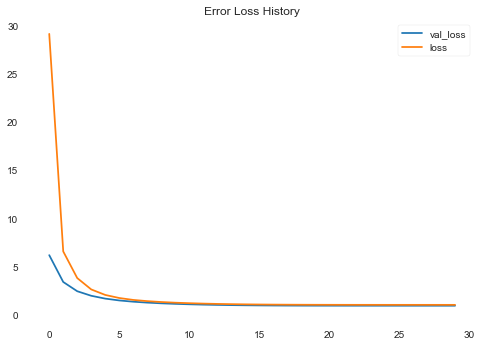

In [23]:
pd.DataFrame.from_dict(clf_3.history_).plot(title='Error Loss History');

# Experiments:
## Using Aggregated, None Contaminated Training Data
The first set of experiments will use the aggregated BGP data, but unlike before, the training
data wont be contaminated with any anomalies.

### Training and Test Set Creation:

In [34]:


#df_normal = df.loc[df["Anomalous"] == -1]
#df_anom   = df.loc[df["Anomalous"] ==  1]


x_train_normal = df_normal[cols[0:37]]
y_train_normal = df_normal["Anomalous"]
y_train_normal.loc[y_train_normal == -1] = 0

x_test_anom = df_anom[cols[0:37]]
y_test_anom = df_anom["Anomalous"]
y_test_anom.loc[y_test_anom == -1] = 0

F:\Anaconda3\envs\bgp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
F:\Anaconda3\envs\bgp\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
F:\Anaconda3\envs\bgp\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.ini

## Model Creation: KNN

In [37]:
clf_4 = KNN(contamination=0.0000000001)
clf_4.fit(x_train_normal.to_numpy())

KNN(algorithm='auto', contamination=1e-10, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [38]:
# get the prediction labels and outlier scores of the training data
y_train_pred_red = clf_4.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_red = clf_4.decision_scores_  # raw outlier scores

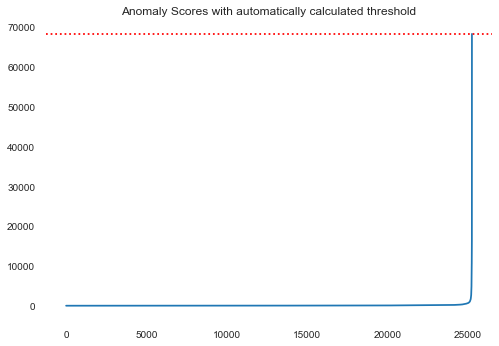

In [41]:
import matplotlib.pyplot as plt
plt.plot(y_train_scores_red));
plt.axhline(y=clf_4.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');